## Importing libraries and setting matplotlib's parameters

In [1]:
import numpy
import random
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import ImageGrid
from src.helpers.funcs import read_conditional_samples
from src.helpers.funcs import *

plt.style.use(["science", "nature"])

import matplotlib
plt.rcParams.update({
    "text.usetex": True})

## Plotting functions

In [2]:
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


def highlight_cell(x_coordinate, y_coordinate, axis=None, **kwargs):
    rect = plt.Rectangle((x_coordinate - .5, y_coordinate - .5), 1, 1, fill=True, **kwargs)
    axis = axis or plt.gca()
    axis.add_patch(rect)
    return rect

def get_color_bar():
    cmap = mpl.colors.ListedColormap(['white', "black"])

    col_dict={0:"white", 1:"black"}
    norm_bins = np.sort([*col_dict.keys()]) + 0.5
    norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)

    norm = mpl.colors.BoundaryNorm(norm_bins, 2, clip=True)

    labels = np.array(["Sandstone", "Shale"])
    fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

    diff = norm_bins[1:] - norm_bins[:-1]
    tickz = norm_bins[:-1] + diff / 2

    colorbar = plt.colorbar(
        mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
        ticks=tickz,
        format=fmt,
        spacing='proportional',
        label='Facies',
    )

    return colorbar

def etype_plot(dict_ti: pd.DataFrame):
    _data = dict_ti.copy()

    fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))

    # Get mean for each row
    _data['etype'] = _data.mean(axis=1)
    ax.imshow(_data['etype'].values.reshape(150, 150),
              cmap='gray', origin='lower')

    # Text settings
    plt.title("Etype of SNESIM simulations")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")

    # Colorbar settings
    cmap = mpl.cm.gray
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                      orientation='vertical', spacing="proportional")
    cb.ax.tick_params()
    cb.set_label("Mean")

    # Saving images to .pdf format
    plt.grid(False)
    plt.savefig("snesim/results/etype.pdf", dpi=600, bbox_inches="tight")
    plt.savefig("snesim/results/etype.png", dpi=600, bbox_inches='tight')
    plt.show()

def calculate_uncertainty(dict_ti: pd.DataFrame):
    _data = dict_ti.copy()

    _data['prob_sand'] = _data.sum(axis=1)
    _data['prob_shale'] = 100 - _data['prob_sand']

    _data["u_max"] = _data[["prob_shale", "prob_sand"]].max(axis=1) / 100
    _data["u_min"] = _data[["prob_shale", "prob_sand"]].min(axis=1) / 100

    _data.drop('prob_sand', axis=1, inplace=True)
    _data.drop('prob_shale', axis=1, inplace=True)

    return _data

def plot_uncertainty(dict_ti: pd.DataFrame):
    _data = dict_ti.copy()

    plt.figure(figsize=(5.5, 4))

    _data = calculate_uncertainty(_data)

    plt.imshow(_data['u_min'].values.reshape(150, 150),
              cmap='gray', origin='lower')

    plt.title("Simulation uncertainty with conditional samples")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")

    # Colorbar settings
    cmap = mpl.cm.gray
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 orientation='vertical', spacing="proportional")
    cb.ax.tick_params()
    cb.set_label("Uncertainty")

    # Saving images to .pdf format
    plt.grid(False)
    plt.savefig('snesim/results/uncertainty.pdf', dpi=500, bbox_inches="tight")
    plt.savefig("snesim/results/uncertainty.png", dpi=600, bbox_inches='tight')
    plt.show()


def plot_realizations_grid(real):
    # Samples 25 TI for a grid of 5x5 images
    rand_idx = [random.randint(0, 99) for _ in range(9)]
    tis_sampled = [real[i] for i in rand_idx]

    fig = plt.figure(figsize=(8, 5))

    image_grid = ImageGrid(fig, 111,
                           nrows_ncols=(3, 3),
                           axes_pad=0.1,
                           cbar_location="left",
                           cbar_pad=0.15)

    cb = get_color_bar()

    fig.suptitle("SNESIM realizations")

    for ax, image in zip(image_grid, tis_sampled):
        # Iterating over the grid returns the Axes.
        ax.imshow(image, cmap="gray", origin="lower")

    plt.savefig("snesim/results/simulation_grid.pdf", dpi=600,
                bbox_inches="tight")
    plt.savefig("snesim/results/simulation_grid.png", dpi=600, bbox_inches='tight')
    plt.show()

def get_sand_shale_proportion(image):
    image = image.reshape(-1)
    sand_prop = (len(np.where(image==1)[0]) / 150**2)*100
    shale_prop = (len(np.where(image==0)[0]) / 150**2)*100
    return sand_prop, shale_prop

def proportions(real: numpy.ndarray) -> None:
    fig, ax = plt.subplots(figsize=(5.5, 4))

    sand_values = list()
    shale_values = list()

    # Get proportions for all
    for i in range(1, len(real)):
        sand, shale = get_sand_shale_proportion(real[i].reshape(-1))
        sand_values.append(sand)
        shale_values.append(shale)

    df_dict = dict(Sand=sand_values, Shale=shale_values)
    df = pd.DataFrame.from_dict(df_dict, orient='columns')

    # Boxplot
    bp = ax.boxplot(df, labels=["Sandstone", "Shale"], patch_artist=True,
                    showmeans=True, showfliers=False)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color="black")

    for patch in bp['boxes']:
        patch.set(facecolor='#f1f1f1')

    plt.ylim(20, 80)

    plt.ylabel('Percentage (%)')
    plt.xlabel('Category')
    plt.title('SNESIM Training Images proportions')

    plt.savefig("snesim/results/boxplot_snesim.pdf", dpi=600,
                bbox_inches='tight')

    plt.savefig("snesim/results/boxplot_snesim.png", dpi=600, bbox_inches='tight')

    plt.show()

def plot_ti(ti: numpy.ndarray) -> None:
    fig, ax = plt.subplots(figsize=(5.5, 4))

    ax.imshow(ti, cmap="gray", origin="lower")
    plt.title("Strebelle training image")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")

    cb = get_color_bar()

    # Saving images to .df format
    plt.grid(False)
    plt.savefig("snesim/results/training_image.pdf", dpi=600, format="pdf",
                bbox_inches='tight')
    plt.savefig("snesim/results/training_image.png", dpi=600, bbox_inches='tight')
    plt.show()

def plot_ti_with_samples(ti: numpy.ndarray) -> None:
    fig, ax = plt.subplots(1, 2, figsize=(6, 8),
                           constrained_layout=True)

    ax[0].imshow(im, cmap="gray", origin="lower")
    ax[0].set_title("Reference training image")
    ax[0].set_xlabel("X coordinate")
    ax[0].set_ylabel("Y coordinate")

    for row_sampled in samples_im.values:
        x, y, class_ = row_sampled[0], row_sampled[1], row_sampled[2]
        if class_ == 0:
            ax[1].scatter(x, y, marker='o', color='black')
        else:
            ax[1].scatter(x, y, marker='o', c='white',
                          edgecolors='black')

    # Plotting the samples
    ax[1].set_title("Location map")
    ax[1].set_xlabel("X coordinate")
    ax[1].set_ylabel("Y coordinate")
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Shale sample',
                              markerfacecolor='black', markeredgecolor="black"),
                       Line2D([0], [0], marker='o', color='w', label='Sandstone sample',
                              markerfacecolor='white', markeredgecolor="black")]

    ax[1].legend(handles=legend_elements, bbox_to_anchor=(1, 0.5), loc="center left")
    ax[1].grid(True, linestyle="--", color="black", linewidth=0.4)

    #get_color_bar()
    plt.gca().set_aspect('equal')
    # Saving images to .pdf forma
    plt.savefig("snesim/results/training_image_samples.pdf", dpi=500, format="pdf",
                bbox_inches='tight')
    plt.savefig("snesim/results/training_image_samples.png", dpi=600, bbox_inches='tight')
    plt.show()

## Reading data

In [3]:
print("[INFO] Loading TI", end="\r")
file = read_conditional_samples("snesim/data/reference_ti")["D"]
im = file.reshape(1, 150, 150)[0, :, :]

conditioning_data = read_conditional_samples("snesim/data/samples50.out")["D"]
# Hard data
print("[INFO] Loading conditional data", end="\r")

# Samples to dataframe
samples_im = pd.DataFrame()

samples_im['x'] = conditioning_data[:,0]
samples_im['y'] = conditioning_data[:,1]
samples_im['class'] = conditioning_data[:,3]

ti_dict = dict()

print("[INFO] Loading simulations", end="\r")
file = read_conditional_samples("snesim/data/snesim_150x150.out")["D"]
realizations = file[:, 0].reshape(100, 150, 150)

for idx, realization in enumerate(realizations):
    ti_dict[f'ti_{idx+1}'] = np.array(realization.reshape(-1))

dataframe = pd.DataFrame(ti_dict)

eas: file ->snesim/data/reference_ti
eas: title->    grid (150x150x1)
eas: file ->snesim/data/samples50.out
eas: title->           eas title
eas: file ->snesim/data/snesim_150x150.out
eas: title-> SNESIM Realizations


## Strebelle

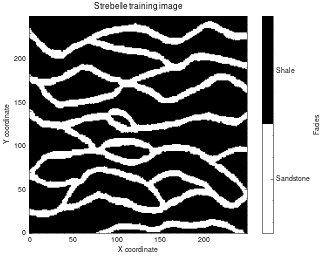

In [4]:
ti = cv2.imread('data/TI/strebelle.png')
plot_ti(ti)

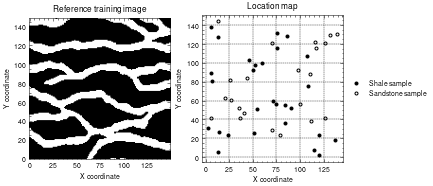

In [6]:
plot_ti_with_samples(ti)

 ## SNESIM output

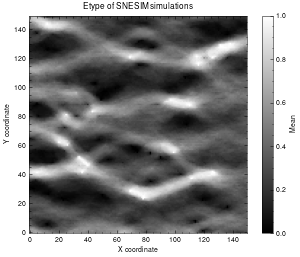

In [7]:
etype_plot(dataframe)

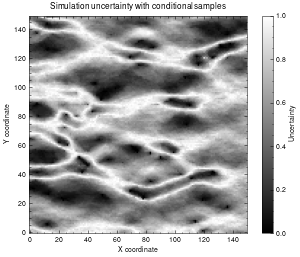

In [8]:
plot_uncertainty(dataframe)

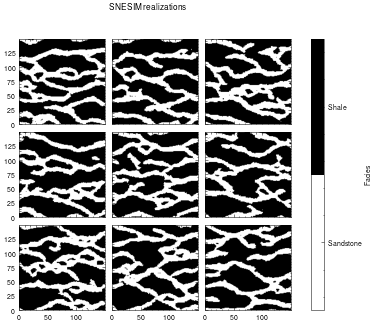

In [9]:
plot_realizations_grid(realizations)

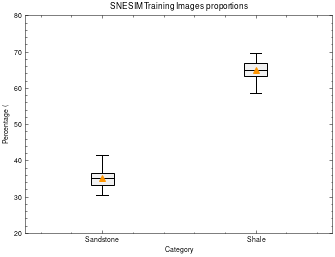

In [10]:
proportions(realizations)